In [1]:
import pandas as pd
import tensorboard as tb
import seaborn as sns
import time
from datetime import timedelta
from matplotlib import pyplot as plt
from tensorboard.backend.event_processing import event_accumulator as ea
from pathlib import Path

In [2]:
# take every X sample for plot (raw log interval: 20k frames) default: 6
DATA_PLOT_SPARSITY = 100

# rolling average sample window (applied after sparsity) default: 4
DATA_PLOT_SMOOTHNESS = 4

MAX_TRAINING_STEPS = 20000000

# in and out dirs
logs_dir = Path.cwd() / Path("logs")
out_dir = Path.cwd() / Path("plots")

# envs to look for in logdir and subdirs and plot
envs = ["Pong", "Boxing", "Freeway"]

# experiments to exclude from plots:
dont_plot = []

# scalars to look for in tfevent files and plot
scalar_to_plot = {
    "tb_name" : "rollout/ep_rew_mean",
    "title" : "Trajectory Return",
    "xlabel": "Frames (M)",
    "ylabel": "Score"}

# human baseline data per env
human_baselines = {
    "Pong" : 14.6,
    "Boxing" : 12.10,
    "Freeway" : 29.6
}

# random baseline data per env
random_baselines = {
    "Pong" : -20.7,
    "Boxing" : 0.10,
    "Freeway" : 0.00
}

In [3]:
for e in envs:
    try:
        human_baselines[e]
        random_baselines[e]
    except KeyError:
        print(f"Error: Baseline data missing for {e}")


def time_str(delta):
    x = str(delta).split(":")
    return f"{x[0]}h {x[1]}m {x[2]}s"
    

# for one env
def get_dfs_for_env(env, everyx=5, smooth_window=5):
    exp_list = []
    list_of_seed_dfs = []
    for p in logs_dir.rglob("*"):
        if p.is_file():
            if env in str(p.parents[0].name):
                split_name = p.parents[0].name.split("-s")
                seed = split_name[-1]
                exp_name = split_name[0]
                if p.parents[0].name in dont_plot:
                    continue
                exp_list.append((seed, p.parents[0]))
    exp_list = set(exp_list) # remove duplicates
    if len(exp_list) == 0:
        return None
    exp_str_list = [int(n[0]) for n in exp_list]
    print(f"{env} : {sorted(exp_str_list)}")
    
    # constructs data_dict as follows:
    # {seed : [(tag, s.step, s.value, seed),...]}
    data_dict = {}
    for seed, log_dir in exp_list:
        max_step  = 0
        max_wt = 0
        curve_id = "PPO"
        for file in log_dir.iterdir():
            if 'tfevents' in file.name:
                acc = ea.EventAccumulator(str(file))
                acc.Reload()
                scalar_list = acc.Tags()['scalars']                        
                key = seed
                for tag in scalar_list:
                    for s in acc.Scalars(tag):
                        if not key in data_dict.keys():
                            data_dict[key] = []
                        data_dict[key].append((tag, s.step, s.value, seed, curve_id, s.wall_time))
                        max_step = s.step if max_step < s.step else max_step
                        max_wt = s.wall_time if max_wt < s.wall_time else max_wt

    # extracts scalar samples from df,
    # processes them (cleaning, skipping and smoothing)
    # and returnsnew df
    def extract_scalar_df(df):
        s = scalar_to_plot["tb_name"]
        scalar_df = df[df["tag"] == s].copy()            
        scalar_df = scalar_df.sort_values(by=["step", "wall_time"], ascending=True)
        scalar_df = scalar_df.drop_duplicates(subset=['step'], keep="last")
        scalar_df = scalar_df.iloc[::everyx, :]
        scalar_df["value"] = scalar_df.value.rolling(smooth_window, min_periods=1).mean()
        return scalar_df[["step", "value", "seed", "curve_id"]]

    # for every seed 
    for k, v in data_dict.items():
        df = pd.DataFrame(v, columns=["tag", "step", "value", "seed", "curve_id", "wall_time"])
        df.step = df.step / 1000000
        list_of_seed_dfs.append(extract_scalar_df(df))

    # merge seed df's to one df, inplace
    return pd.concat(list_of_seed_dfs, ignore_index=True)

In [4]:
data_to_plot = {}

# goes over every specified env and
# creates dict: {env : df, env2 : df, ...}
for e in envs:
    res_df = get_dfs_for_env(e, DATA_PLOT_SPARSITY, DATA_PLOT_SMOOTHNESS)
    if res_df is not None:
        data_to_plot[e] = res_df

Pong : [0, 8, 16]
Boxing : [0, 8, 16]
Freeway : [0, 8, 16]


[0, 'Pong']
[1, 'Boxing']
[2, 'Freeway']


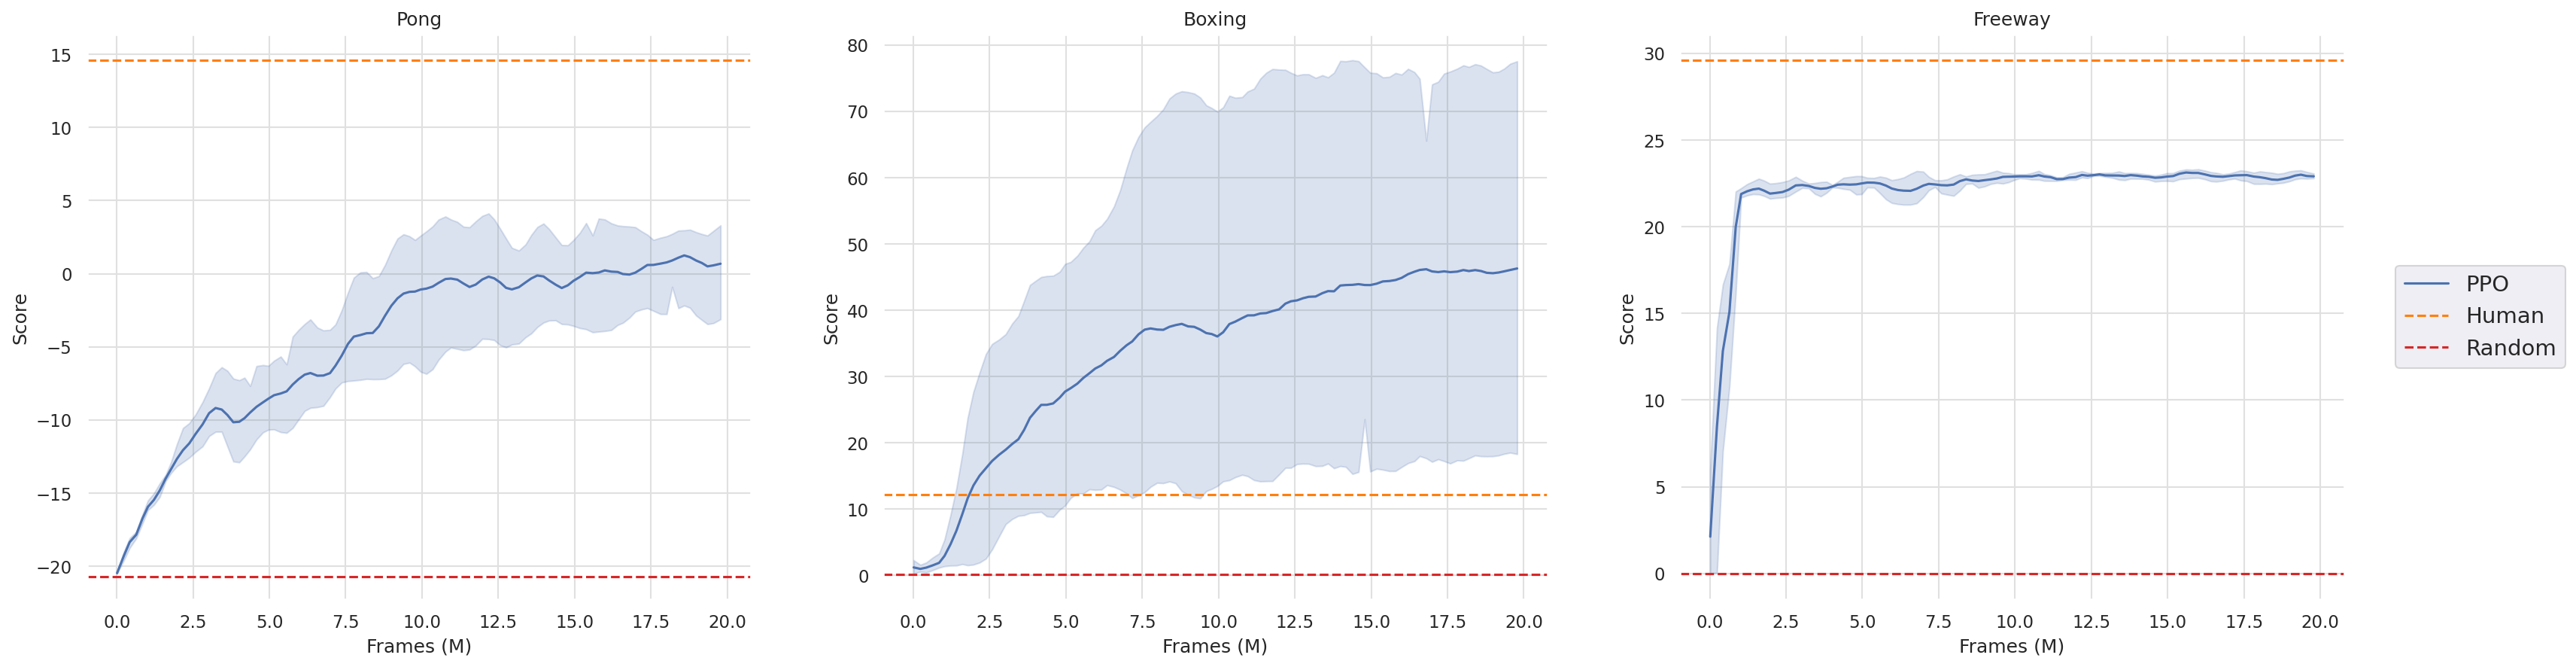

In [19]:
sns.set_theme()
fig_width = 20
no_envs = len(data_to_plot)
width_per_plot = fig_width / no_envs
fig_size = (fig_width, width_per_plot)
fig = plt.figure(figsize=fig_size, dpi=150)
axes = fig.subplots(1, no_envs)

# env interator
for i, (env, data) in enumerate(data_to_plot.items()):
    print([i, env])
    ax = axes[i]
    order = sorted(data["curve_id"].unique())
    ax = sns.lineplot(data=data, x="step", y="value", hue="curve_id", hue_order=order, ax=ax)
    ax.axhline(human_baselines[env], linestyle="--", color="tab:orange", label="Human") #human
    ax.axhline(random_baselines[env], linestyle="--", color="tab:red", label="Random") #random
    
    ax.set_facecolor('white')
    ax.grid(color='#e0e0e0', linestyle='-', linewidth=1)
    ax.get_legend().remove()
    ax.set(
        xlabel = scalar_to_plot["xlabel"],
        ylabel = scalar_to_plot["ylabel"],
        title  = env)
axes[-1].legend(loc='center right', bbox_to_anchor=(1.35, 0.5), fontsize=14)
plt.subplots_adjust(top = 0.9, bottom=0.15, left=0, right=1)
plt.show(fig)
fig.savefig(out_dir / "results.png", bbox_inches='tight')